In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import scipy.fftpack as spfft

import sys
sys.path.insert(0, '../src/')

import methods
import scipy.io as sio
import scipy.linalg as splin
import time

## Load data

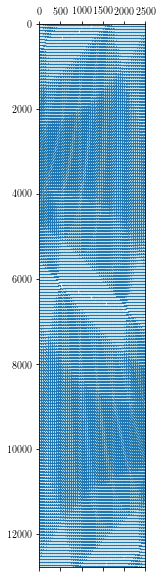

In [2]:
# matrix_data = sio.loadmat("./data/fancurved.mat")
matrix_data = sio.loadmat("../data/fanlinear.mat")
# matrix_data = sio.loadmat("./data/parallel.mat")

A = matrix_data["A"].toarray()
m, n = A.shape
plt.figure(figsize=(30, 10))
plt.spy(A, markersize=0.1)

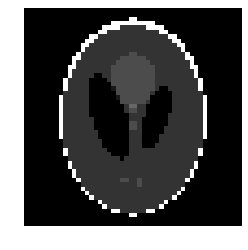

In [3]:
x_true = sio.loadmat("../data/shepplogan.mat")["x"]

n1d = int(np.sqrt(x_true.shape[0]))
im = np.reshape(x_true, (n1d, n1d), order="F")
plt.imshow(im, cmap="gray")
_ = plt.axis("off")

In [4]:
b = A.dot(x_true)
print(A.shape, b.shape)

(12780, 2500) (12780, 1)


## Check that the system is consistent

In [5]:
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]
print(np.linalg.norm(A.dot(x_lstsq) - b) / np.linalg.norm(b))

1.9808450501663975e-15


In [6]:
preprocess_time = {
#     "$\gamma = 1$": 0,
    "$\gamma = 2$": 0,
    "$\gamma = 3$": 0,
}
sketch_sizes = [i * n for i in range(2, 4)]
P = {name: [] for name in preprocess_time}

### Check condition number of $A$

In [35]:
cond_A = np.linalg.cond(A)
print("Condition numberr of the matrix A = {}".format(cond_A))

Condition numberr of the matrix A = 402.6603644875797


## Create preconditioners from sketched submatrix

In [7]:
for k, i in enumerate(range(2, 4)):
    print("Sketch size = {}".format(n * i))
    st = time.time()
    sketch_idx = np.sort(np.random.choice(np.arange(m), sketch_sizes[k], replace=False))
    Q, R_qr = np.linalg.qr(A[sketch_idx, :])
#     print(np.linalg.cond(R_qr))
    try:
        P["$\gamma = {}$".format(i)] = np.linalg.inv(R_qr)
    except np.linalg.LinAlgError as err:
        print(err)
        P["$\gamma = {}$".format(i)] = np.linalg.pinv(R_qr, rcond=1e-6)
    preprocess_time["$\gamma = {}$".format(i)] = time.time() - st

Sketch size = 5000
Sketch size = 7500


## Initialize Kaczmarz method with and without preconditioners

In [14]:
# Maximum number of iterations
max_iter = 5e9
# Required tolerance, but now is ignored
tol = 1e-6
x0 = np.zeros(n)
# Time of start using preconditioner.
# First ```start_prec``` seconds we run simple Kaczmarz method and 
# after this time is exceeded, run its preconditioned version to get high accurate solution 
start_prec = 120
# Maximum number of seconds for running considered methods
max_time = 300
# Store iterand every ```log_interval``` iterations
log_interval = 1000

In [15]:
conv_x_res = {"No preconditioning": []}
conv_time_res = {"No preconditioning": []}

In [16]:
res = methods.classical_kaczmarz(A, b, x0, max_iter, max_time, log_interval)
conv_x_res["No preconditioning"] = res["conv_x"]
conv_time_res["No preconditioning"] = res["conv_time"]

In [17]:
for name in preprocess_time:
    print(name)
    res = methods.precond_kaczmarz(A, b, P[name], 
                             x0, max_iter, max_time, 
                             log_interval, preprocess_time[name], start_prec)
    conv_x_res[name] = res["conv_x"]
    conv_time_res[name] = res["conv_time"]

$\gamma = 2$
$\gamma = 3$


In [24]:
relative_residual_norm = {}
for name in conv_x_res:
    relative_residual_norm[name] = []
    if P.get(name) is None:
        for x in conv_x_res[name]:
            relative_residual_norm[name].append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
    else:
        time_range = conv_time_res[name][::log_interval] + [conv_time_res[name][-1]]
        for i, x in enumerate(conv_x_res[name]):
            if time_range[i] - time_range[0] >= start_prec:
                relative_residual_norm[name].append(np.linalg.norm(A @ (P[name] @ x) - b) / np.linalg.norm(b))
            else:
                relative_residual_norm[name].append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))

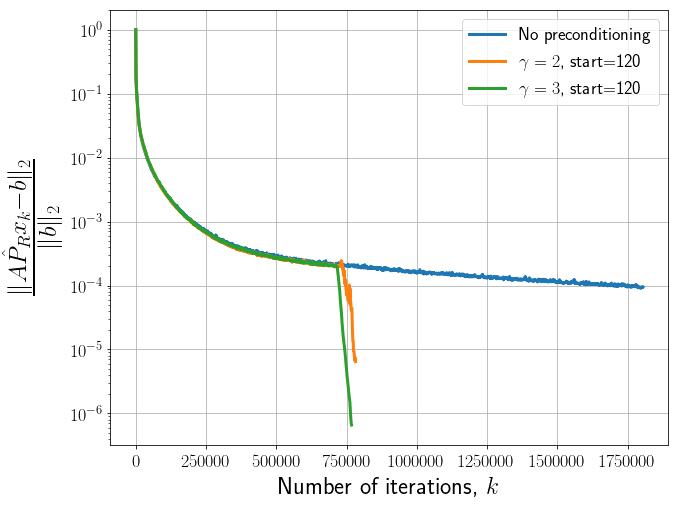

In [29]:
plt.figure(figsize=(10, 8))

for name in relative_residual_norm:
    iter_range = [j * log_interval for j in range(len(conv_x_res[name]))]
    if P.get(name) is None:
        plt.semilogy(iter_range, relative_residual_norm[name], label=name, 
                     linewidth=3)
    else:
        plt.semilogy(iter_range, relative_residual_norm[name], label=name + ", start={}".format(start_prec), 
                     linewidth=3)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=36)
plt.xlabel(r"Number of iterations, $k$", fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
_ = plt.yticks(fontsize=18)
_ = plt.xticks(fontsize=18)

No preconditioning
300.00011801719666
$\gamma = 2$
302.17500591278076
$\gamma = 3$
302.7922887802124


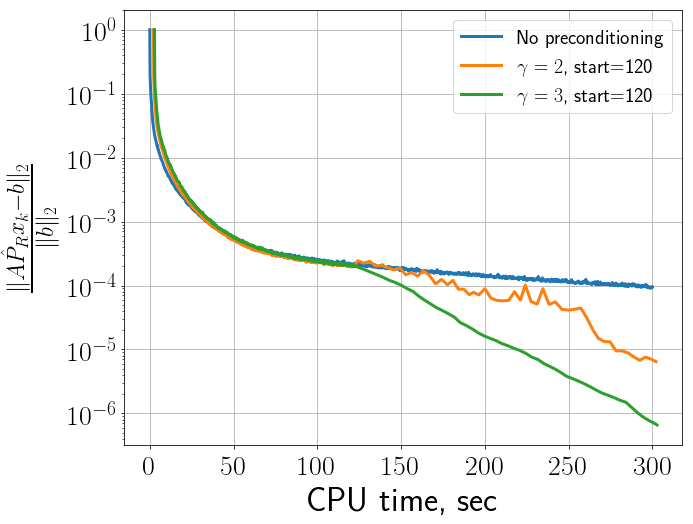

In [31]:
plt.figure(figsize=(10, 8))

for name in relative_residual_norm:
    print(name)
    time_range = conv_time_res[name][::log_interval] + [conv_time_res[name][-1]]
    print(time_range[-1])
    if P.get(name) is None:
        plt.semilogy(time_range, relative_residual_norm[name], label=name, linewidth=3)
    else:
        plt.semilogy(time_range, relative_residual_norm[name], label=name + ", start={}".format(start_prec), 
                     linewidth=3)

plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=34)
plt.xlabel(r"CPU time, sec", fontsize=34)
plt.legend(fontsize=20)
_ = plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=28)
plt.grid(True)

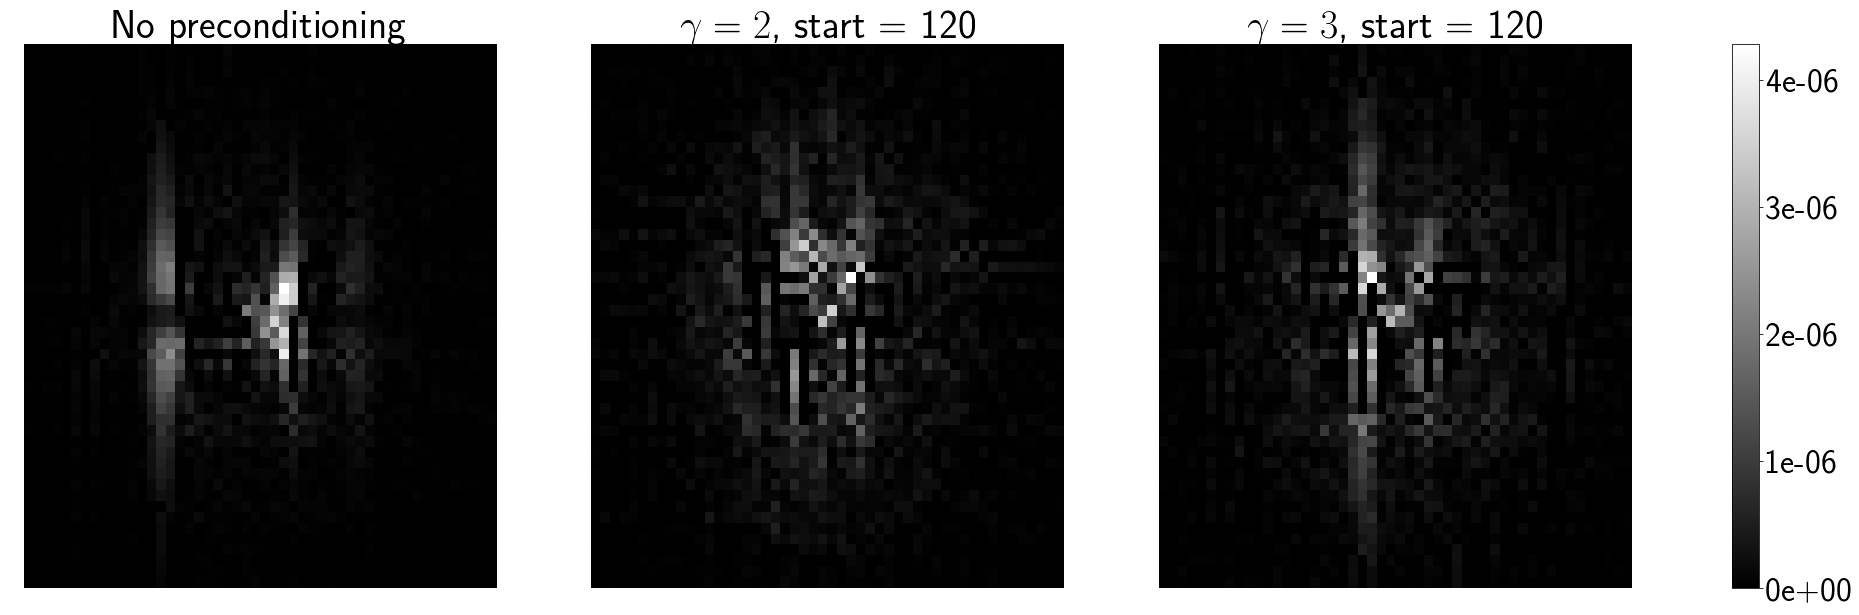

In [34]:
n1d = int(np.sqrt(A.shape[1]))
x_all = {}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 10))
for (i, name), ax in zip(enumerate(conv_x_res.keys()), axes.flat):
    if P.get(name) is None:
        x = conv_x_res[name][-1]
        title = name
    else:
        x = P[name] @ conv_x_res[name][-1]
        title = name + ", start = {}".format(start_prec)
    x = np.clip(x, 0, 1)
    x_all[name] = np.reshape(x, (n1d, n1d), order="F")
    im_ax = ax.imshow(abs(x_all[name] - im) / np.linalg.norm(im), cmap="gray")
    ax.set_title(title, fontsize=40)
    ax.set_aspect("auto")
    ax.axis("off")

cbar = fig.colorbar(im_ax, ax=axes.ravel().tolist(), format='%.0e')
cbar.ax.tick_params(labelsize=34)